In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
import pandas as pd
from sklearn import linear_model
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from scipy import stats

from datetime import date
from dateutil.relativedelta import relativedelta

%matplotlib inline
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

from sklearn.preprocessing import StandardScaler
import random

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (18, 4)

In [2]:
inputdata1 = "../output_combined/" 
outputdata1 = "../output_qt/regressiondata_qt/"

extended_data_quarterly = "a0_combinedQuarterly_extended_ARIMA.csv"
#extended_data_quarterly = "a0_combinedQuarterly_extended_ETS.csv"


In [3]:
def get_data():
    get_data = pd.read_csv(inputdata1 + extended_data_quarterly, parse_dates=[0], index_col=0)
    first_date = get_data.index[0]

    get_data.index = pd.date_range(first_date, get_data.index[-1], freq='QS').date
    return get_data

df = get_data()
df.tail()

,gdp_total,imports_goods_services,household_cons,gov_consumption,investments,gpd_invest_business_households,gov_invest,change_supply,exports_goods_services,gdp_total_deseasonalized,...,BeloningSeizoengecorrigeerd_2,Loonkosten_7,BeloningVanWerknemers_8,Netherlands_GDP,Germany_GDP,France_GDP,Italy_GDP,Spain_GDP,Belgium_GDP,Europe_GDP
2023-07-01,228414.0,171477.0,102709.0,57861.0,44106.0,36472.000000,7632.000000,-645.0,195610.0,233430.0,...,122579.000000,112442.000000,7.200000,176795.2,689738.0,509770.5,393014.5,283945.8,94081.9,4601.4
2023-10-01,238600.0,173911.0,101295.0,62754.0,46748.0,39030.000000,7716.000000,757.0,200918.0,233920.0,...,124838.000000,127017.000000,7.400000,184719.1,703189.3,537957.1,398467.5,296525.9,103879.4,4672.7
2024-01-01,227490.0,169869.0,103451.0,56957.0,48067.0,41072.000000,6996.000000,-2696.0,191652.0,233310.0,...,125942.305123,120632.655639,7.341663,174208.1,692676.4,523911.8,383284.2,283422.3,97196.1,4138.8
2024-04-01,242922.0,177551.0,103869.0,62360.0,50843.0,43096.000000,7745.000000,-1752.0,205224.0,235834.0,...,126997.736947,137205.067346,7.358679,187841.1,680335.2,523676.7,395005.9,297267.4,101762.3,4472.8
2024-07-01,232265.0,177048.0,104280.0,59590.0,44121.0,40562.584779,7758.081766,-68.0,201137.0,237780.0,...,128009.922911,119971.928640,7.353716,179833.7,690652.2,518759.1,395404.7,295005.9,95239.9,4523.7


In [4]:

# subset of the data
df1 = df[[
        # 'gdp_total',
        # 'imports_goods_services',
        # 'household_cons',
        # 'gov_consumption', 
        # 'investments', 
        # 'gpd_invest_business_households',
        # 'gov_invest', 
        # 'change_supply', 
        # 'exports_goods_services',
        'gdp_total_deseasonalized', 
        'imports_goods_services_deseasonalized',
        'household_cons_deseasonalized', 
        'gov_consumption_deseasonalized',
        'investments_deseasonalized',
        'gpd_invest_business_households_deseasonalized',
        'gov_invest_deseasonalized', 
        'change_supply_deseasonalized',
        'exports_goods_services_deseasonalized',
        'BeloningSeizoengecorrigeerd_2', 
        'Loonkosten_7',
        'BeloningVanWerknemers_8', 
        'Germany_GDP',
        'France_GDP', 
        'Italy_GDP', 
        'Spain_GDP', 
        'Belgium_GDP' 
        ]]

### Start date

In [5]:
df1.index = pd.DatetimeIndex(df1.index)
start_date_analysis = '1998-01-01'  
save_some_data_for_predictions ='2024-07-01'

df1 = df1.loc[start_date_analysis:save_some_data_for_predictions,:]

### Save transformations of GDP

In [6]:
#############################
# change name if seasonally adjusted for code consistency
#############################
if(any([col for col in df1.columns if 'gdp_total_deseasonalized' in col])):
    df1.insert(0, 'gdp_total', df1.pop('gdp_total_deseasonalized'))


GDP_TRANSFORMATIONS = df1.loc[:,['gdp_total']].copy()
GDP_TRANSFORMATIONS.index = pd.DatetimeIndex(GDP_TRANSFORMATIONS.index)

### Add 'sure' data and random data

In [7]:

# create a sure-fire predictor
df1['gdp_total_dirty_0'] = [random.random() * 20000 for _ in range(0, len(df1))] + df1['gdp_total']
df1['gdp_total_dirty_1'] = [random.random() * 20000 for _ in range(0, len(df1))] + df1['gdp_total']

# randos
df1['random_0'] = [random.random() for _ in range(0, len(df1))] 
df1['random_1'] = [random.random() for _ in range(0, len(df1))] 

# trend
df1['trend'] = [i for i in range(0, len(df1))]

print(df1.shape)

(107, 22)


### Drop if number of observations less than GDP

In [8]:
def dropifObsLessThanGDP(data):

    describe = data.describe()
    descr = describe.loc['count',:].sort_values(ascending=True)

    # Drop columns with values less than gdp_total
    gdpObservations = descr['gdp_total']

    cols = descr[descr < gdpObservations].index.tolist()
    print(cols)

    data.drop(columns=cols, inplace=True)

    return data
    

df1 = dropifObsLessThanGDP(df1)

[]


### Log and scale data

In [9]:
# scale data to make comparable

def log_data(data,seasonal_only = True):

    if seasonal_only:
        df2 = np.log(data.loc[:, ~data.columns.isin(['change_supply_deseasonalized', 'BeloningVanWerknemers_8', 'trend'])])
        df2['change_supply_deseasonalized'] =data['change_supply_deseasonalized']
        df2['BeloningVanWerknemers_8']= data['BeloningVanWerknemers_8'] 
        df2['trend']= data['trend'] 
        data = df2.copy()

    else:
        df2 = np.log(data.loc[:, ~data.columns.isin(['change_supply', 'change_supply_deseasonalized', 'BeloningVanWerknemers_8', 'trend'])])
        df2['change_supply_deseasonalized'] =data['change_supply_deseasonalized']
        df2['BeloningVanWerknemers_8']= data['BeloningVanWerknemers_8'] 
        df2['trend']= data['trend'] 
        data = df2.copy()

    GDP_TRANSFORMATIONS['gdp_total_logged'] = df2.loc[:, ['gdp_total']]
    

    return data, GDP_TRANSFORMATIONS

# df1, GDP_TRANSFORMATIONS = log_data(df1, seasonal_only=True)
# df1.head()

### Standard Scaler

,gdp_total,gdp_total_scaled
1998-01-01,149317.0,-1.939067
1998-04-01,150392.0,-1.891425
1998-07-01,151706.0,-1.833192
1998-10-01,152911.0,-1.779790
1999-01-01,155808.0,-1.651403
...,...,...
2023-07-01,233430.0,1.788599
2023-10-01,233920.0,1.810315
2024-01-01,233310.0,1.783281
2024-04-01,235834.0,1.895138


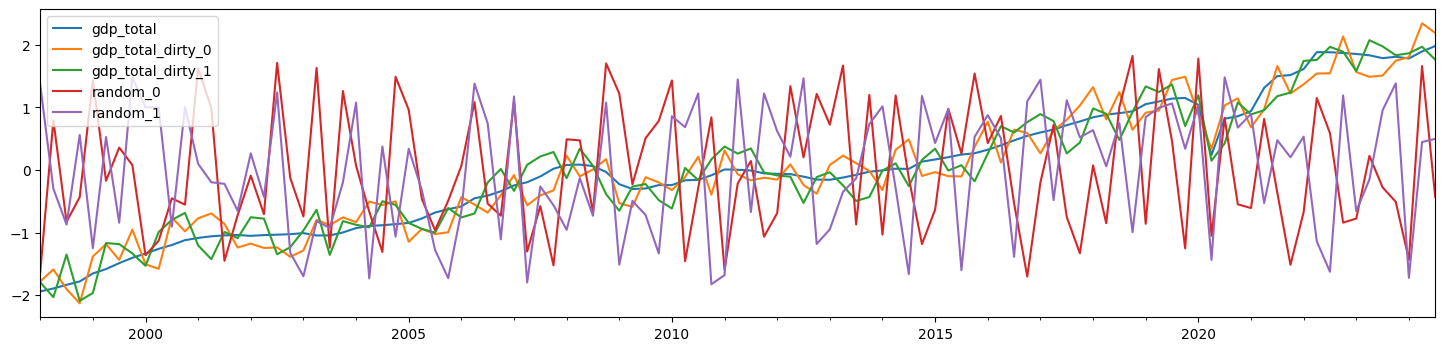

In [10]:
scaler = StandardScaler()
df1_scaled = scaler.fit_transform(df1)

scaled_features_df = pd.DataFrame(df1_scaled, index=df1.index, columns=df1.columns)
scaled_features_df[['gdp_total','gdp_total_dirty_0','gdp_total_dirty_1', 'random_0', 'random_1']].plot()


#############################
GDP_TRANSFORMATIONS['gdp_total_scaled'] = scaled_features_df.loc[:, ['gdp_total']]
GDP_TRANSFORMATIONS

In [11]:
#############################
# Dataframe of column names for storing tests
#############################

STORE_FOR_TESTS = pd.DataFrame(columns=scaled_features_df.columns).T

STORE_FOR_TESTS['Qt_Seasonality'] = np.nan
STORE_FOR_TESTS['Semi_Seasonality'] = np.nan
STORE_FOR_TESTS['Level_Stationary'] = np.nan
STORE_FOR_TESTS['Difference_Stationary'] = np.nan
STORE_FOR_TESTS['Difference_Data'] = 'False'

In [12]:
def seasonality_test(data):
    kw_test1 = data.iloc[0:100,:]
    kw_test1['Qts'] = [1,2,3,4] * int(len(kw_test1)/4)
    kw_test1['Semi'] = [1,2] * int(len(kw_test1)/2)
    kw_test1.dropna(inplace=True)
    
    return kw_test1

kw1 = seasonality_test(scaled_features_df)

### Deseasonalize if needed (Kruskal-Wallis test)

(107, 22)


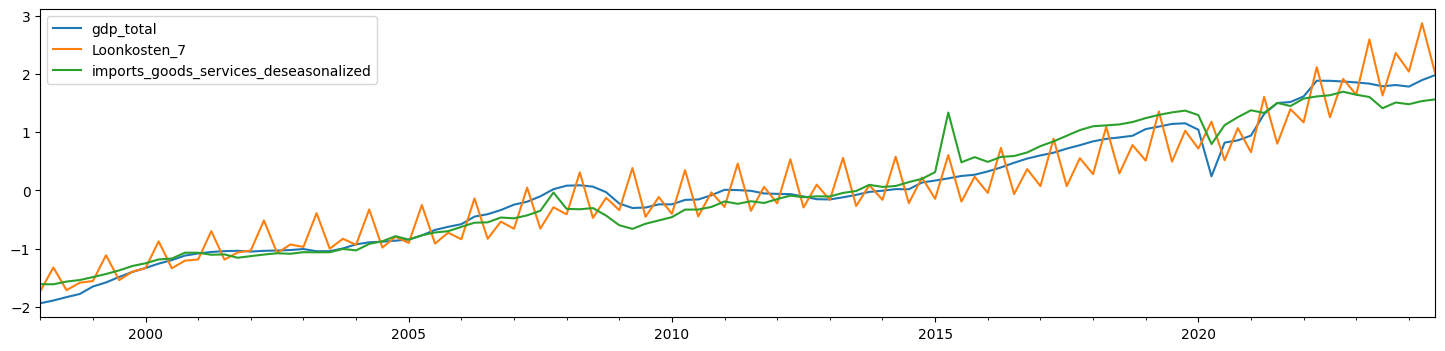

In [13]:
scaled_features_df[['gdp_total', 'Loonkosten_7', 'imports_goods_services_deseasonalized']].plot()

print(df1.shape)

In [14]:
def Kruskal_Wallis_Qt(data, STORE_FOR_TESTS): # Quarterly seasonality
    
    for col in data.columns:
        # no need to test these
        if (col == 'Qts' or col == 'Semi'):
            continue
        res = []
        for i in data['Qts'].unique():
            res.append(data[data['Qts'] == i][col].values)
        results = stats.kruskal(*res)
        if (results[1] > 0.50):  #p-value
            STORE_FOR_TESTS.loc[col,'Qt_Seasonality'] = 'No_Qt_Seasonality'
        else:
            STORE_FOR_TESTS.loc[col, 'Qt_Seasonality'] = 'Qt_Seasonality'

    return STORE_FOR_TESTS

STORE_FOR_TESTS = Kruskal_Wallis_Qt(kw1, STORE_FOR_TESTS)

In [15]:
def Kruskal_Wallis_Semi(data, STORE_FOR_TESTS): # Semi yearly
    
    for col in data.columns:
        # no need to test
        if (col == 'Qts' or col == 'Semi'):
            continue
        res = []
        for i in data['Semi'].unique():
            res.append(data[data['Semi'] == i][col].values)
        results = stats.kruskal(*res)
        if (results[1] > 0.50):  #p-value
            STORE_FOR_TESTS.loc[col, 'Semi_Seasonality'] = 'No_Semi_Seasonality'
        else:
            STORE_FOR_TESTS.loc[col, 'Semi_Seasonality'] = 'Semi_Seasonality'

    return STORE_FOR_TESTS

STORE_FOR_TESTS = Kruskal_Wallis_Semi(kw1, STORE_FOR_TESTS)

In [16]:
# Select feature if contains seasonality (so "No_ not present in name", then deseasonalize)
scaled_features_df.dropna(inplace=True)

deseasonalizeThese = STORE_FOR_TESTS[~STORE_FOR_TESTS['Semi_Seasonality'].str.contains("No_")].index
print(deseasonalizeThese)

for i in deseasonalizeThese:

    smdt = scaled_features_df[i]

    if any(smdt < 0):
        smdata = sm.tsa.seasonal_decompose(scaled_features_df[i], model='additive', period=4, extrapolate_trend='freq')
        scaled_features_df.loc[:, i] = smdata.trend
    else:
        smdata = sm.tsa.seasonal_decompose(scaled_features_df[i], model='multiplicative', period=4, extrapolate_trend='freq')
        scaled_features_df.loc[:, i] = smdata.trend

scaled_features_df.loc['2024-07-01':]


Index(['change_supply_deseasonalized', 'Loonkosten_7', 'France_GDP',
       'Italy_GDP', 'Spain_GDP', 'Belgium_GDP', 'random_0'],
      dtype='object')


,gdp_total,imports_goods_services_deseasonalized,household_cons_deseasonalized,gov_consumption_deseasonalized,investments_deseasonalized,gpd_invest_business_households_deseasonalized,gov_invest_deseasonalized,change_supply_deseasonalized,exports_goods_services_deseasonalized,BeloningSeizoengecorrigeerd_2,...,Germany_GDP,France_GDP,Italy_GDP,Spain_GDP,Belgium_GDP,gdp_total_dirty_0,gdp_total_dirty_1,random_0,random_1,trend
2024-07-01,1.98138,1.563379,2.204164,1.926638,1.462052,1.523016,0.815486,-2.656635,1.609824,2.462446,...,1.42626,1.724452,1.714726,1.905414,1.750497,2.190539,1.764489,-0.385474,0.498234,1.715938


[ 1  2  3  6  7  8 10 13 14 16 17]
['household_cons_deseasonalized', 'gov_consumption_deseasonalized', 'investments_deseasonalized', 'change_supply_deseasonalized', 'exports_goods_services_deseasonalized', 'BeloningSeizoengecorrigeerd_2', 'BeloningVanWerknemers_8', 'Italy_GDP', 'Spain_GDP', 'gdp_total_dirty_0', 'gdp_total_dirty_1']


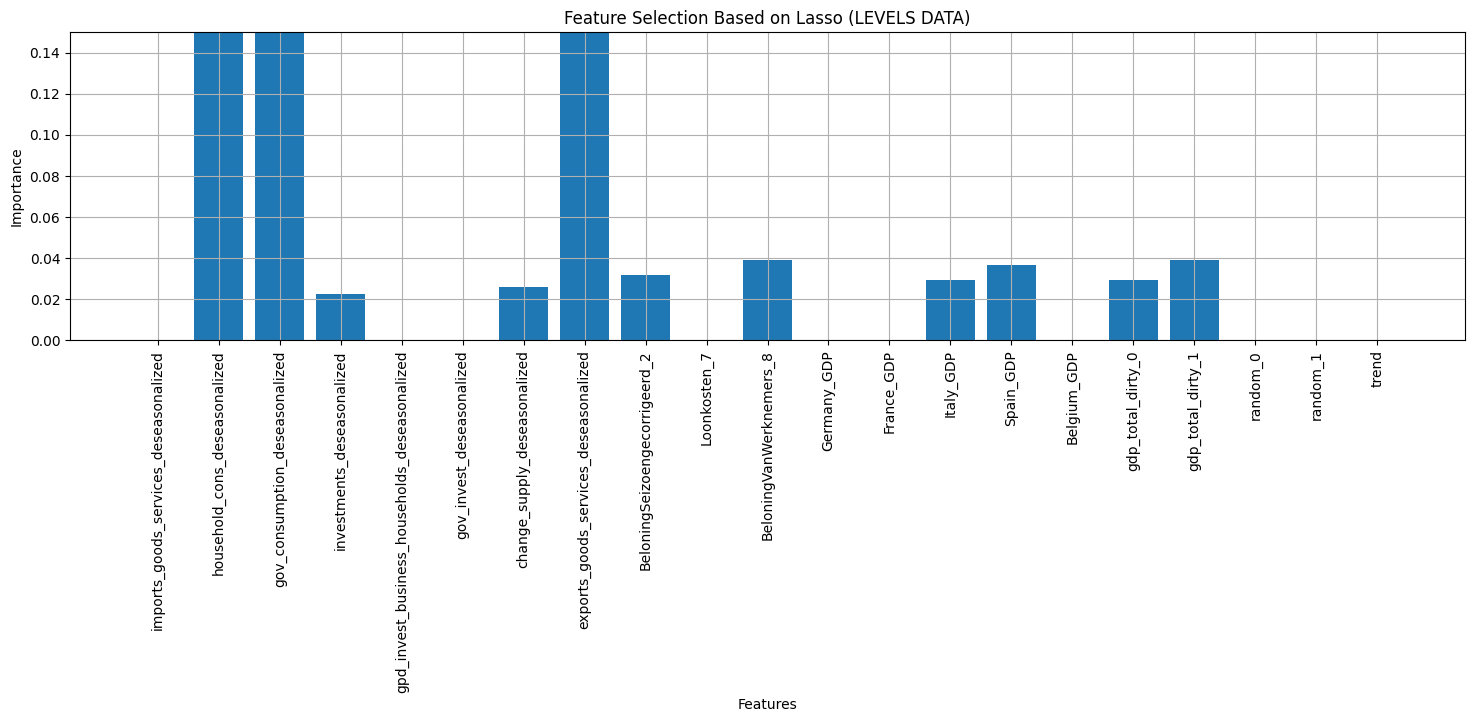

(107, 22)


In [17]:
def lassoreg(data, alpha=0.0001, title='Feature Selection Based on Lasso'):

    myalpha = alpha
    data1 = data.copy()
    data1 = data1.dropna()

    Xcolnames =  data1.iloc[:, 1:]

    Y = data1.iloc[:, 0].values
    X = data1.iloc[:, 1:].values

    ### assertions
    # does X contain gdptotal, it should not
    assert X.shape[1] == data.shape[1] - 1

    # does X contain gdptotal, it should not
    val = 'gdp_total'
    lst = Xcolnames.columns
    assert val not in lst

    # regression
    lasso = Lasso(alpha = myalpha, fit_intercept=False, max_iter=10000)
    
    lasso.fit(X,Y)

    selected_features_lasso = np.flatnonzero(lasso.coef_)
    print(selected_features_lasso)

    best_variables = [Xcolnames.columns[i] for i in selected_features_lasso]
    print(best_variables)


    # calling the model with the best parameter
    lasso1 = Lasso(alpha=myalpha)
    lasso1.fit(X, Y)

    # Using np.abs() to make coefficients positive.  
    lasso1_coef = np.abs(lasso1.coef_)

    # plotting the Column Names and Importance of Columns. 
    plt.bar(lst, lasso1_coef)
    plt.xticks(rotation=90)
    plt.grid()
    plt.title(title)
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.ylim(0, 0.15)
    plt.show()

    return best_variables

lassoreg(scaled_features_df, alpha=0.01, title='Feature Selection Based on Lasso (LEVELS DATA)')

print(scaled_features_df.shape)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
['imports_goods_services_deseasonalized', 'household_cons_deseasonalized', 'gov_consumption_deseasonalized', 'investments_deseasonalized', 'gpd_invest_business_households_deseasonalized', 'gov_invest_deseasonalized', 'change_supply_deseasonalized', 'exports_goods_services_deseasonalized', 'BeloningSeizoengecorrigeerd_2', 'Loonkosten_7', 'BeloningVanWerknemers_8', 'Germany_GDP', 'France_GDP', 'Italy_GDP', 'Spain_GDP', 'Belgium_GDP', 'gdp_total_dirty_0', 'gdp_total_dirty_1', 'random_0', 'random_1', 'trend']


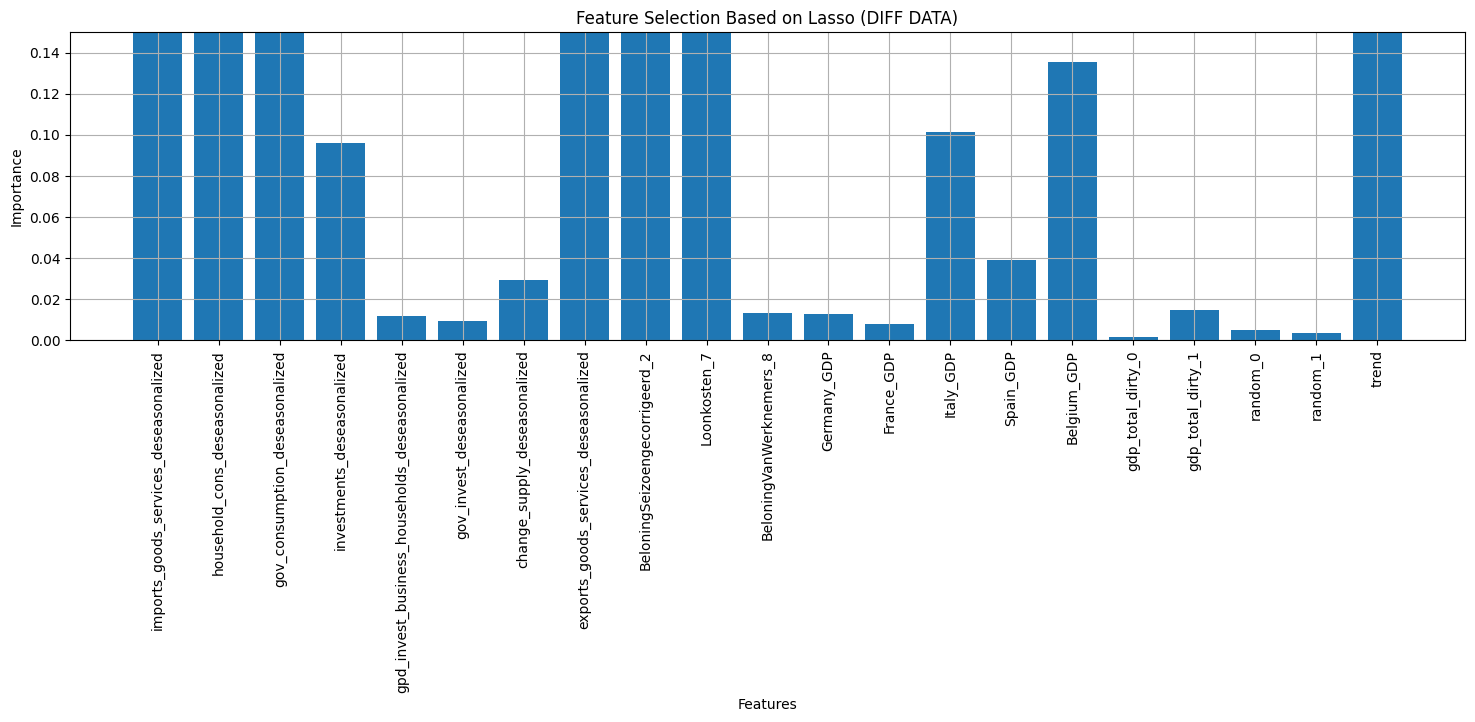

['imports_goods_services_deseasonalized',
 'household_cons_deseasonalized',
 'gov_consumption_deseasonalized',
 'investments_deseasonalized',
 'gpd_invest_business_households_deseasonalized',
 'gov_invest_deseasonalized',
 'change_supply_deseasonalized',
 'exports_goods_services_deseasonalized',
 'BeloningSeizoengecorrigeerd_2',
 'Loonkosten_7',
 'BeloningVanWerknemers_8',
 'Germany_GDP',
 'France_GDP',
 'Italy_GDP',
 'Spain_GDP',
 'Belgium_GDP',
 'gdp_total_dirty_0',
 'gdp_total_dirty_1',
 'random_0',
 'random_1',
 'trend']

In [18]:
lassoreg(scaled_features_df.diff().dropna(), alpha=0.0, title='Feature Selection Based on Lasso (DIFF DATA)') 

In [19]:
df1 = scaled_features_df.copy()
number_lags = 1

df = df1.iloc[:,:]

for lag in range(1, number_lags+1):
    for col in df.columns:
        df[col + '_lag_' + str(lag)] = df[col].shift(lag)
    
selectThese = [col for col in df.columns if '_lag_' in col]
selectThese = ['gdp_total', 'gdp_total_dirty_0', 'gdp_total_dirty_1','random_0', 'random_1'] + selectThese 
df_lag = df[selectThese]

print(df_lag.shape)


(107, 27)


[ 0  1  2  3  6  7  8 10 11 12 14 15 17 18 19 22 24 25]
['gdp_total_dirty_0', 'gdp_total_dirty_1', 'random_0', 'random_1', 'household_cons_deseasonalized_lag_1', 'gov_consumption_deseasonalized_lag_1', 'investments_deseasonalized_lag_1', 'gov_invest_deseasonalized_lag_1', 'change_supply_deseasonalized_lag_1', 'exports_goods_services_deseasonalized_lag_1', 'Loonkosten_7_lag_1', 'BeloningVanWerknemers_8_lag_1', 'France_GDP_lag_1', 'Italy_GDP_lag_1', 'Spain_GDP_lag_1', 'gdp_total_dirty_1_lag_1', 'random_1_lag_1', 'trend_lag_1']


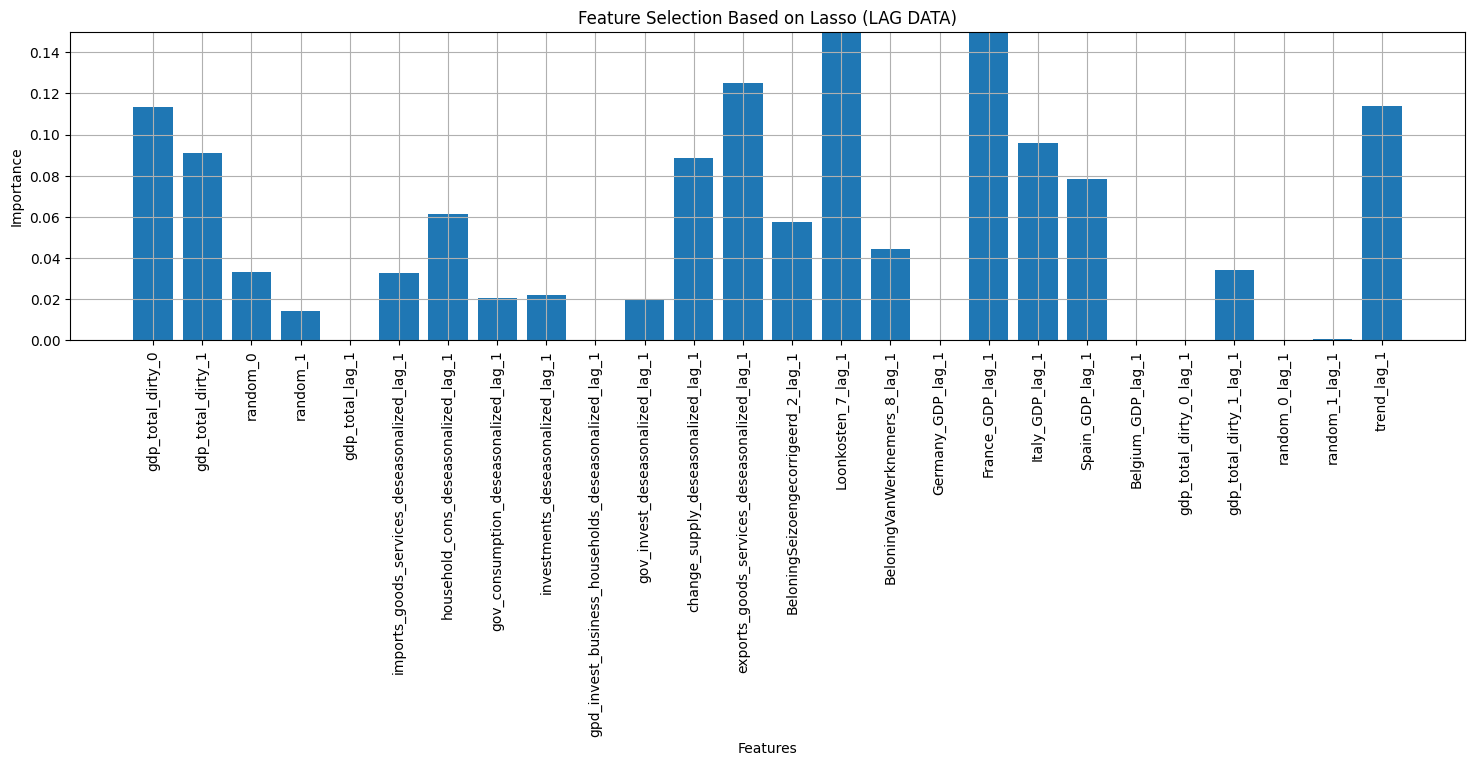

['gdp_total_dirty_0',
 'gdp_total_dirty_1',
 'random_0',
 'random_1',
 'household_cons_deseasonalized_lag_1',
 'gov_consumption_deseasonalized_lag_1',
 'investments_deseasonalized_lag_1',
 'gov_invest_deseasonalized_lag_1',
 'change_supply_deseasonalized_lag_1',
 'exports_goods_services_deseasonalized_lag_1',
 'Loonkosten_7_lag_1',
 'BeloningVanWerknemers_8_lag_1',
 'France_GDP_lag_1',
 'Italy_GDP_lag_1',
 'Spain_GDP_lag_1',
 'gdp_total_dirty_1_lag_1',
 'random_1_lag_1',
 'trend_lag_1']

In [20]:
lassoreg(df_lag, alpha=0.001, title='Feature Selection Based on Lasso (LAG DATA)') 

[ 0  1  2  3  4  5  6  7 10 11 13 16 17 18 19]
['imports_goods_services_deseasonalized', 'household_cons_deseasonalized', 'gov_consumption_deseasonalized', 'investments_deseasonalized', 'gpd_invest_business_households_deseasonalized', 'gov_invest_deseasonalized', 'change_supply_deseasonalized', 'exports_goods_services_deseasonalized', 'BeloningVanWerknemers_8', 'Germany_GDP', 'Italy_GDP', 'gdp_total_dirty_0', 'gdp_total_dirty_1', 'random_0', 'random_1']


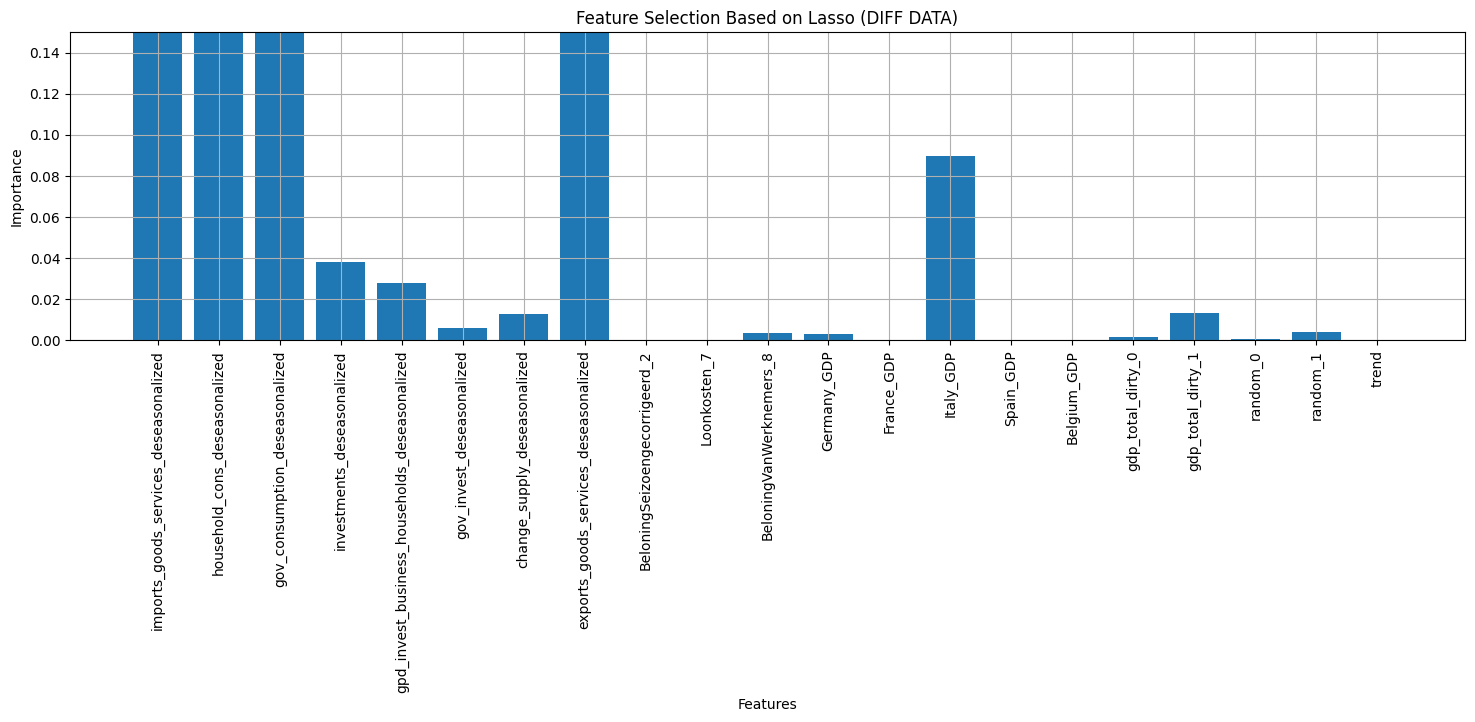

In [21]:
lassoreg(scaled_features_df.diff().dropna(), alpha=0.0001, title='Feature Selection Based on Lasso (DIFF DATA)'); 

[ 0  1  2  3  6  9 10 15 16 17 18 21 22 23 24]
['gdp_total_dirty_0', 'gdp_total_dirty_1', 'random_0', 'random_1', 'household_cons_deseasonalized_lag_1', 'gpd_invest_business_households_deseasonalized_lag_1', 'gov_invest_deseasonalized_lag_1', 'BeloningVanWerknemers_8_lag_1', 'Germany_GDP_lag_1', 'France_GDP_lag_1', 'Italy_GDP_lag_1', 'gdp_total_dirty_0_lag_1', 'gdp_total_dirty_1_lag_1', 'random_0_lag_1', 'random_1_lag_1']


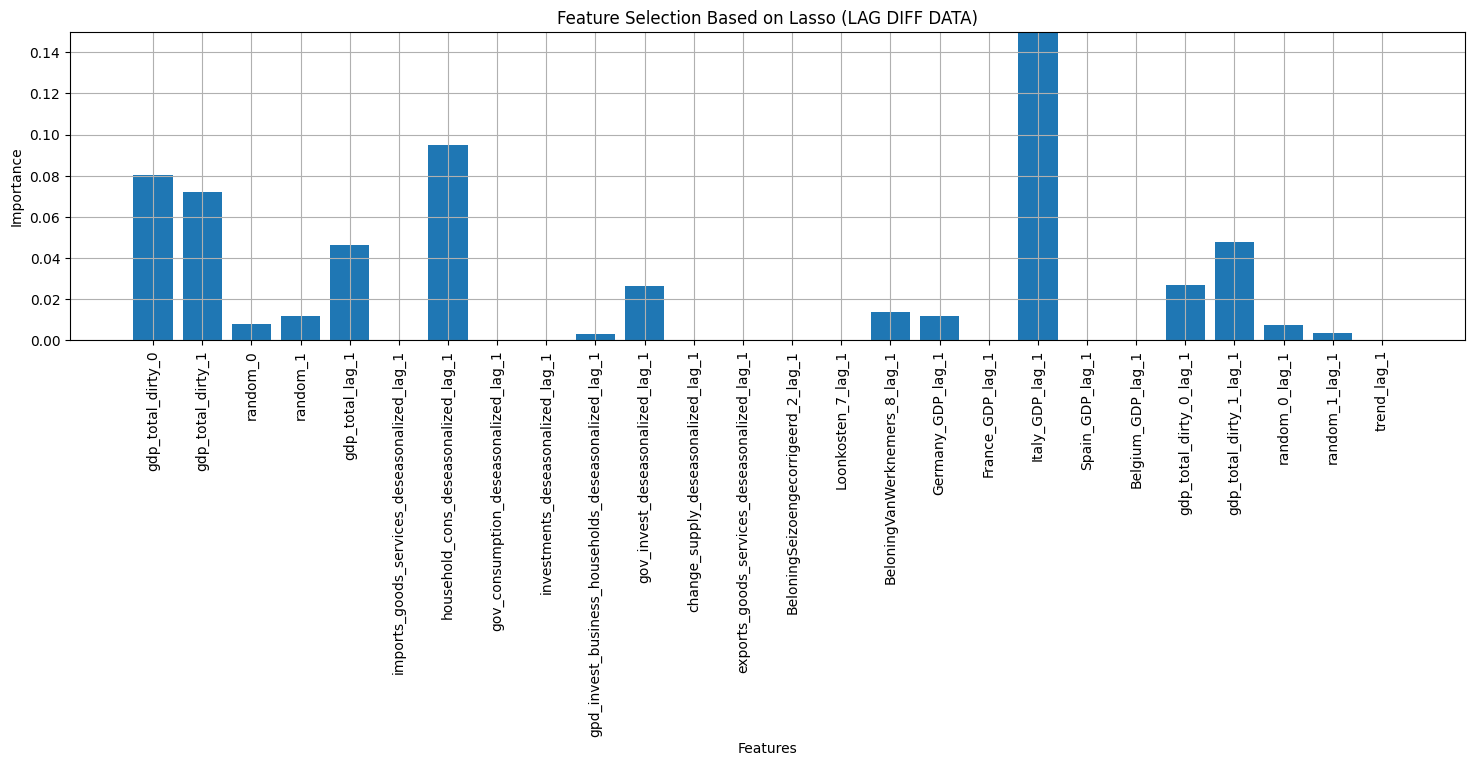

['gdp_total_dirty_0',
 'gdp_total_dirty_1',
 'random_0',
 'random_1',
 'household_cons_deseasonalized_lag_1',
 'gpd_invest_business_households_deseasonalized_lag_1',
 'gov_invest_deseasonalized_lag_1',
 'BeloningVanWerknemers_8_lag_1',
 'Germany_GDP_lag_1',
 'France_GDP_lag_1',
 'Italy_GDP_lag_1',
 'gdp_total_dirty_0_lag_1',
 'gdp_total_dirty_1_lag_1',
 'random_0_lag_1',
 'random_1_lag_1']

In [22]:
lassoreg(df_lag.diff().dropna(), alpha=0.001, title='Feature Selection Based on Lasso (LAG DIFF DATA)') 


### Make sure data is stationary

In [23]:

# adf test, if critical value is greater than test statistic, then the series is not stationary

def adf_test(timeseries, verbose=False):
    if verbose:
        print ('Results of Dickey-Fuller Test:')
    
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    
    if verbose:
        print (dfoutput)
        print(dftest)

    if dftest[0] > dftest[4]['5%']:
        if verbose:
            print('ADF: Time Series is not Stationary')
       
        return "NotStationary"
    else:
        if verbose:    
            print('ADF: Time Series is Stationary') 
        return "Stationary" 


# adf_test(timeseries, verbose=True)   


In [24]:

def kpss_test(timeseries, verbose=False):

    if verbose:
        print ('Results of KPSS Test:')

    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    
    if verbose:
        print (kpss_output)
        print(kpsstest[0])
        print(kpsstest[3])

    if kpsstest[0] > kpsstest[3]['5%']:
        if verbose:
            print('KPSS: Time Series is not Stationary')
        return "NotStationary"
    else: 
        if verbose:   
            print('KPSS: Time Series is Stationary')
        return "Stationary"

# kpss_test(timeseries, verbose=True) 

### Loop through KPSS and ADF tests, mark those series that need to be differenced

In [25]:
def stationdarydf(mydata, STORE_FOR_TESTS, form='Levels', save=False):

    stationary_features = []
    seriesLength = []

    for col in mydata.columns:

        timeseries = mydata[col].dropna()
        seriesLength.append(len(timeseries))

        adf1 = adf_test(timeseries, verbose=False)
        kpss1 = kpss_test(timeseries, verbose=False)
        if adf1 == "Stationary" and kpss1 == "Stationary":
            stationary_features.append('Stationary')
            if form == 'Levels':
                STORE_FOR_TESTS.loc[col, 'Level_Stationary'] = 'Stationary'
            else:
                STORE_FOR_TESTS.loc[col, 'Difference_Stationary'] = 'Stationary'
        else:
            stationary_features.append('NotStationary')
            if form == 'Levels':
                STORE_FOR_TESTS.loc[col, 'Level_Stationary'] = 'NotStationary' 
            else:
                STORE_FOR_TESTS.loc[col, 'Difference_Stationary'] = 'NotStationary'
        
    df = pd.DataFrame(data = [mydata.columns, stationary_features, seriesLength]).T
    df.columns = ['Feature', 'Stationary', 'Length']    

    if save:
        df.to_csv(outputdata1 + "startionarity.csv")

    return df, STORE_FOR_TESTS

form = 'Levels'
df, STORE_FOR_TESTS = stationdarydf(scaled_features_df, STORE_FOR_TESTS, form, save=False)

print(df.shape)


(22, 3)


### If not stationary, difference, then test for stationarity again

In [26]:

def differenceData(originalData, STORE_FOR_TESTS, mydiff=1):

    ## which features are not stationary
    # function from above
    stat1, _ = stationdarydf(originalData, STORE_FOR_TESTS, form, save=False)
    # collect
    stat2 = stat1[stat1['Stationary'].str.contains('NotStationary')]
    notstationary = stat2['Feature'].tolist()

    # dont change orginal data
    stationarydf_diff = originalData.copy()

    # selectively difference the data
    for i in notstationary:
        stationarydf_diff[i] = stationarydf_diff[i].diff(mydiff)

    # rename columns
    for col in notstationary:
        STORE_FOR_TESTS.loc[col, "Difference_Data"] = "True"
    
    scaled_features_df_diff = stationarydf_diff.copy()

    return scaled_features_df_diff, STORE_FOR_TESTS

scaled_features_df_diff, STORE_FOR_TESTS = differenceData(scaled_features_df, STORE_FOR_TESTS, mydiff=1)

GDP_TRANSFORMATIONS['gdp_total_scaled_diff'] = scaled_features_df_diff.loc[:, ['gdp_total']]

print(scaled_features_df_diff.shape)


(107, 22)


In [27]:
form = 'Differenced'
df1, STORE_FOR_TESTS = stationdarydf(scaled_features_df_diff, STORE_FOR_TESTS, form, save = 'False')
STORE_FOR_TESTS

,Qt_Seasonality,Semi_Seasonality,Level_Stationary,Difference_Stationary,Difference_Data
gdp_total,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
imports_goods_services_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
household_cons_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
gov_consumption_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
investments_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
gpd_invest_business_households_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
gov_invest_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
change_supply_deseasonalized,No_Qt_Seasonality,Semi_Seasonality,NotStationary,Stationary,True
exports_goods_services_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
BeloningSeizoengecorrigeerd_2,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,NotStationary,True


<Axes: >

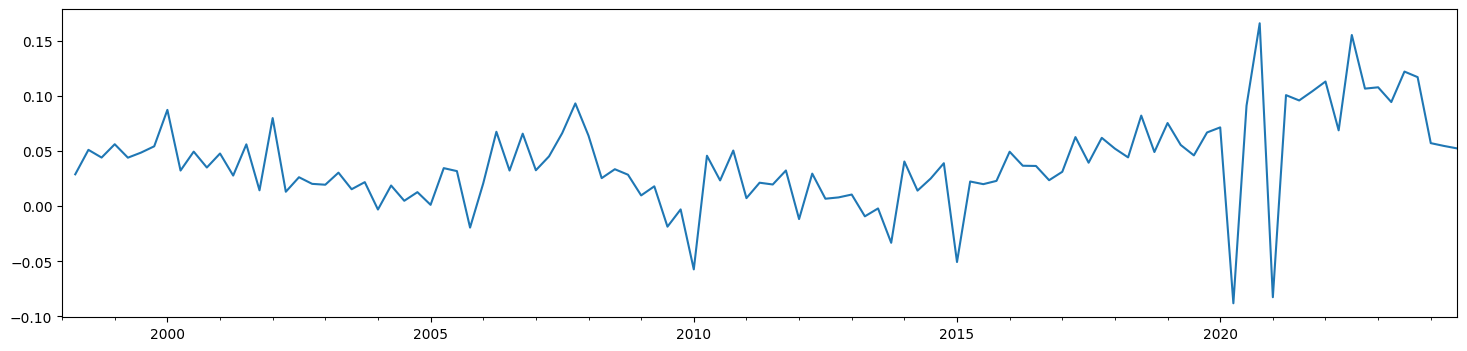

In [28]:
scaled_features_df_diff['BeloningSeizoengecorrigeerd_2'].plot()

[ 1  2  4  7 10 11 13 16 17 19]
['household_cons_deseasonalized', 'gov_consumption_deseasonalized', 'gpd_invest_business_households_deseasonalized', 'exports_goods_services_deseasonalized', 'BeloningVanWerknemers_8', 'Germany_GDP', 'Italy_GDP', 'gdp_total_dirty_0', 'gdp_total_dirty_1', 'random_1']


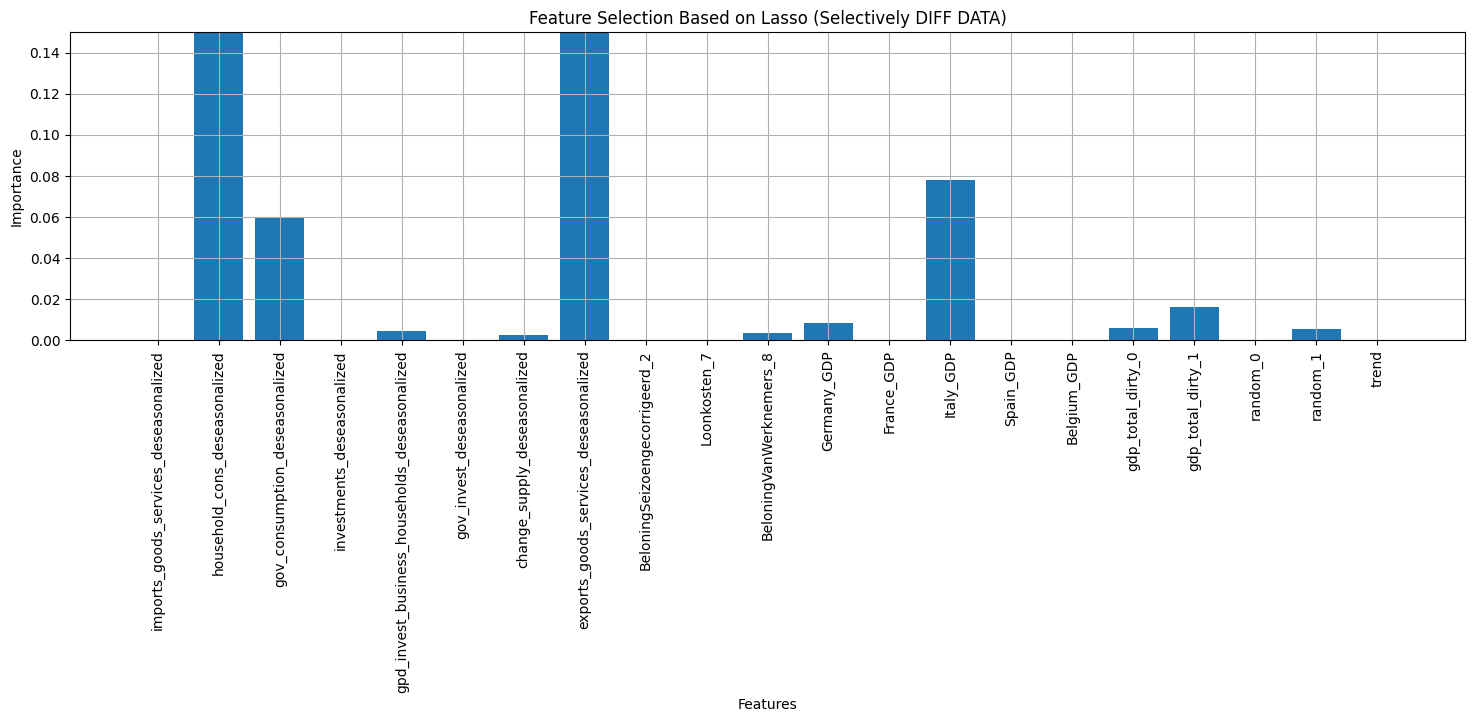

['household_cons_deseasonalized',
 'gov_consumption_deseasonalized',
 'gpd_invest_business_households_deseasonalized',
 'exports_goods_services_deseasonalized',
 'BeloningVanWerknemers_8',
 'Germany_GDP',
 'Italy_GDP',
 'gdp_total_dirty_0',
 'gdp_total_dirty_1',
 'random_1']

In [29]:
lassoreg(scaled_features_df_diff.dropna(), alpha=0.001, title='Feature Selection Based on Lasso (Selectively DIFF DATA)') 

(107, 22)


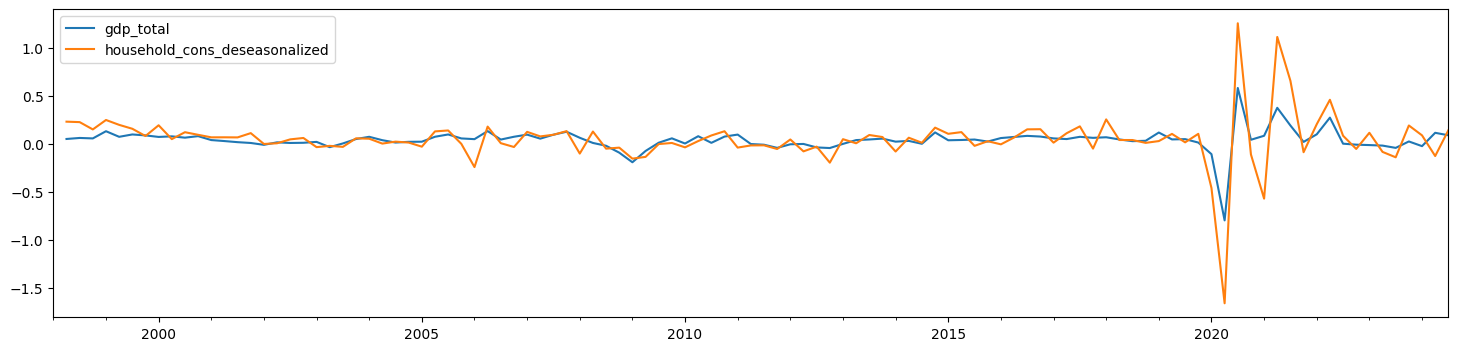

In [30]:
scaled_features_df_diff[['gdp_total', 'household_cons_deseasonalized']].plot()
scaled_features_df_diff.columns

print(scaled_features_df_diff.shape)

In [31]:
df = scaled_features_df_diff.copy()
number_lags = 1

for lag in range(1, number_lags+1):
    for col in df.columns:
        df[col + '_lag_' + str(lag)] = df[col].shift(lag)
    
selectThese = [col for col in df.columns if '_lag_' in col]
df_lag = df[selectThese]

scaled_features_df_diff_lag = scaled_features_df_diff.merge(df_lag, left_index=True, right_index=True)

print(scaled_features_df_diff_lag.shape)


(107, 44)


In [32]:
### Select if lagged 

chooseThese = ['gdp_total'] + [x for x in scaled_features_df_diff_lag.columns if '_lag' in x]
scaled_features_df_diff_lag_subset = scaled_features_df_diff_lag[chooseThese]


In [33]:
### Remove 'sure' data

removeThese = ['gdp_total_dirty_0_lag_1', 'gdp_total_dirty_1_lag_1', 'random_0_lag_1', 'random_1_lag_1']
scaled_features_df_diff_lag_subset = scaled_features_df_diff_lag_subset.loc[:, ~scaled_features_df_diff_lag_subset.columns.isin(removeThese)]

print(scaled_features_df_diff_lag_subset.shape)

(107, 19)


[ 0  2  6  8 12 13 14]
['gdp_total_lag_1', 'household_cons_deseasonalized_lag_1', 'gov_invest_deseasonalized_lag_1', 'exports_goods_services_deseasonalized_lag_1', 'Germany_GDP_lag_1', 'France_GDP_lag_1', 'Italy_GDP_lag_1']


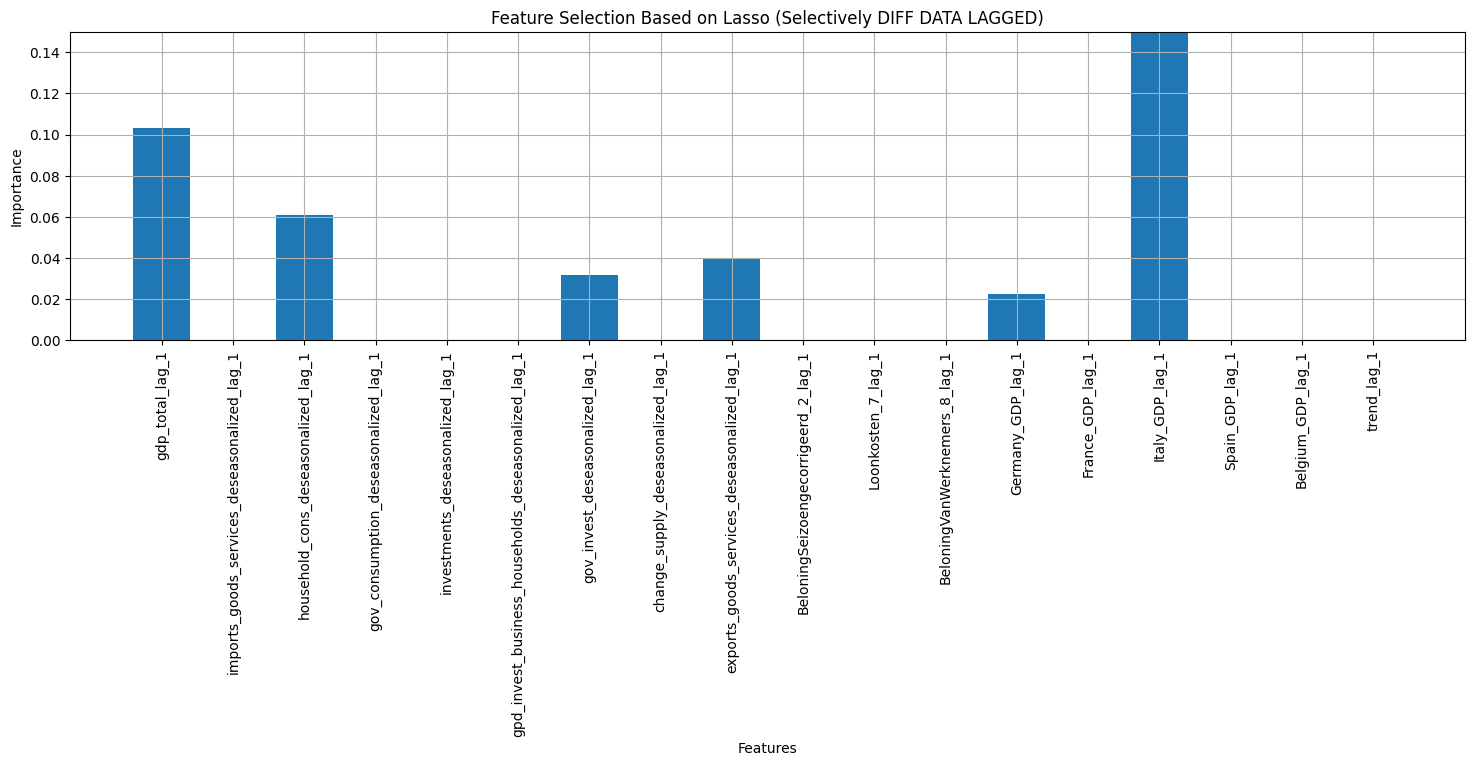

In [34]:
lasout = lassoreg(scaled_features_df_diff_lag_subset.dropna(), alpha=0.001, title='Feature Selection Based on Lasso (Selectively DIFF DATA LAGGED)') 

,gdp_total,gdp_total_lag_1,household_cons_deseasonalized_lag_1,gov_invest_deseasonalized_lag_1,exports_goods_services_deseasonalized_lag_1,Germany_GDP_lag_1,France_GDP_lag_1,Italy_GDP_lag_1
1998-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-04-01,0.047641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-07-01,0.058233,0.047641,0.227821,-0.114522,0.048581,0.030207,0.069092,0.062269
1998-10-01,0.053402,0.058233,0.223121,0.026428,0.021150,0.245965,0.076292,0.079707
1999-01-01,0.128387,0.053402,0.147068,0.212894,0.039362,0.135929,0.055191,0.033335
...,...,...,...,...,...,...,...,...
2023-07-01,-0.045159,-0.021361,-0.086965,-0.262814,-0.083521,-0.283723,0.035152,0.001107
2023-10-01,0.021716,-0.045159,-0.143207,0.414042,-0.128636,0.186631,0.046808,0.005490
2024-01-01,-0.027034,0.021716,0.188200,-0.339162,0.097865,0.222232,0.034608,0.024337
2024-04-01,0.111857,-0.027034,0.085286,-0.231981,-0.062271,-0.173686,0.035915,0.036742


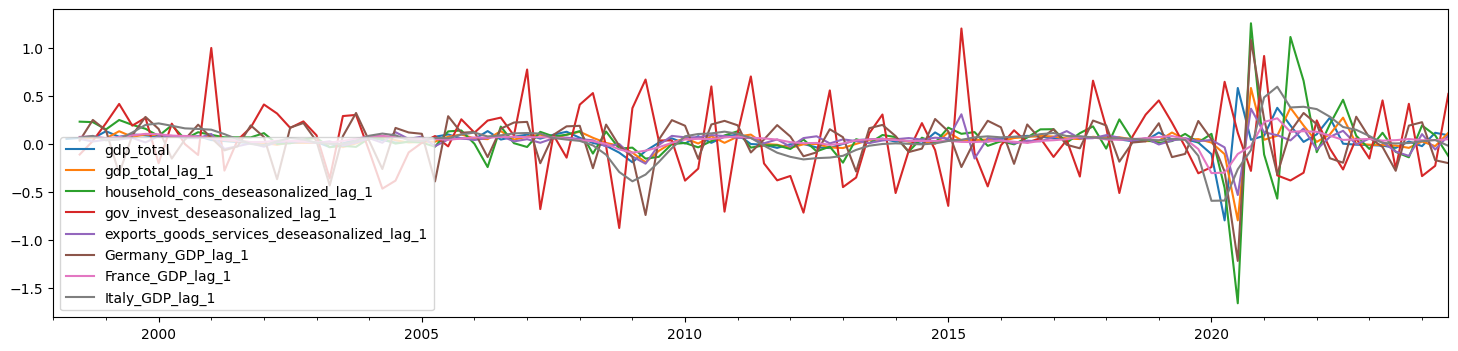

In [35]:
chooseThese = ['gdp_total'] + lasout
scaled_features_df_diff_lag[chooseThese].plot()
scaled_features_df_diff_lag[chooseThese]

<Axes: >

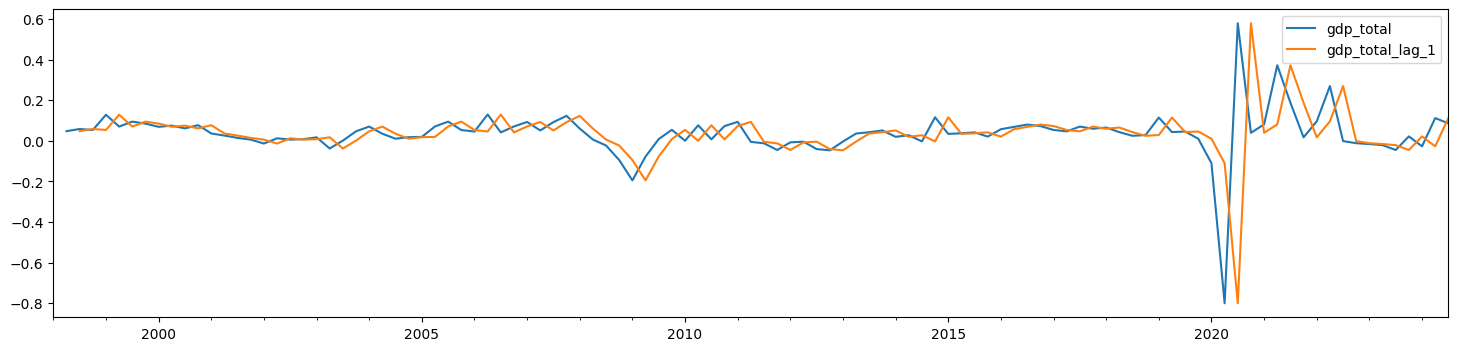

In [36]:
scaled_features_df_diff_lag[['gdp_total','gdp_total_lag_1']].plot()

In [37]:
reg1 = scaled_features_df_diff_lag[chooseThese]
reg1.to_csv("tmp.csv")

reg1.dropna(inplace=True)

##################################
test_start_date = start_date_analysis
end_test_date = '2024-03-01'
##################################

X = reg1.loc[test_start_date:end_test_date, chooseThese[1]:]
X = sm.add_constant(X)

y_true = reg1.loc[test_start_date:end_test_date:, 'gdp_total']

model = sm.OLS(y_true,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              gdp_total   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     12.18
Date:                Tue, 31 Dec 2024   Prob (F-statistic):           5.15e-11
Time:                        12:55:02   Log-Likelihood:                 106.45
No. Observations:                 103   AIC:                            -196.9
Df Residuals:                      95   BIC:                            -175.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

<Axes: >

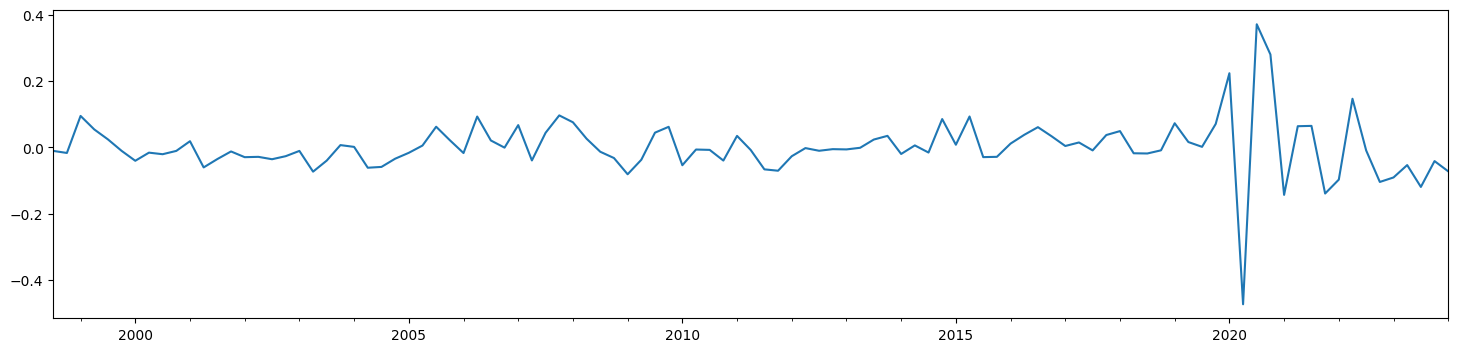

In [38]:
results.resid.plot()

<Axes: >

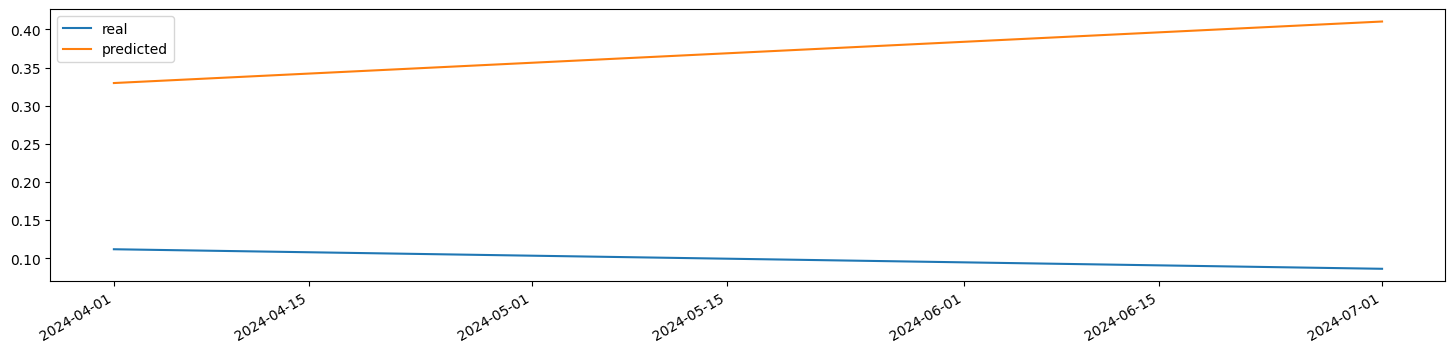

In [39]:
ypred = results.predict(X)
Xnew = reg1.loc[end_test_date:, chooseThese[1]:]
Xnew[['const']] = 1
reg1.loc[end_test_date:, ['gdp_total']]

ynewpred = results.predict(Xnew)  # predict out of sample

# plot real and predicted values
df_pred = pd.DataFrame({'real': reg1.loc[end_test_date:, 'gdp_total'], 'predicted': ynewpred})
df_pred.plot()


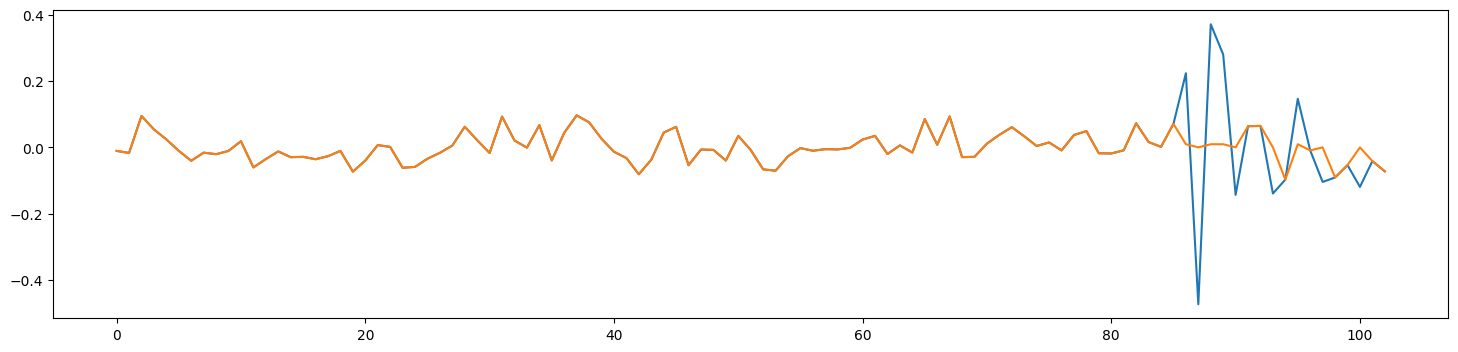

In [40]:

plt.plot(np.arange(0,(len(results.resid))), results.resid)
### Remove Covid for tests
results.resid[results.resid < -0.10] = np.mean(results.resid)
results.resid[results.resid > 0.10] = np.mean(results.resid)
plt.plot(np.arange(0,(len(results.resid))), results.resid)


### Homoskedasticity

In [41]:

homoske = sm.stats.diagnostic.het_breuschpagan(results.resid, X)
if homoske[1] < 0.10:
    print('Heteroskedasticity (Breusch-Pagan)')
else:
    print('Homoskedasticity (Breusch-Pagan)')

Homoskedasticity (Breusch-Pagan)


In [42]:
# Null hypothesis is homoscedastic and correctly specified.

homoske = sm.stats.diagnostic.het_white(results.resid, X)

if homoske[1] < 0.10:
    print('Heteroskedasticity (White)')
else:
    print('Homoskedasticity (White)')

Homoskedasticity (White)


### Colinearity

In [43]:
def dw_test(resids):

    dw1 = sm.stats.stattools.durbin_watson(resids, axis=0)
    print(dw1)

    if dw1 > 2.0:
        if (4 - dw1) < 1.8: 
            print("Negative autoceorrelation is significant")
        else:
            print("Negative autocorrelation is not significant")
    else:
        if dw1 < 1.8:
            print("Positive autocorrelation is significant")
        else:
            print("Positive autocorrelation is not significant")

dw_test(results.resid)

1.3605960598058844
Positive autocorrelation is significant


### Normality

Residuals are not normally distributed


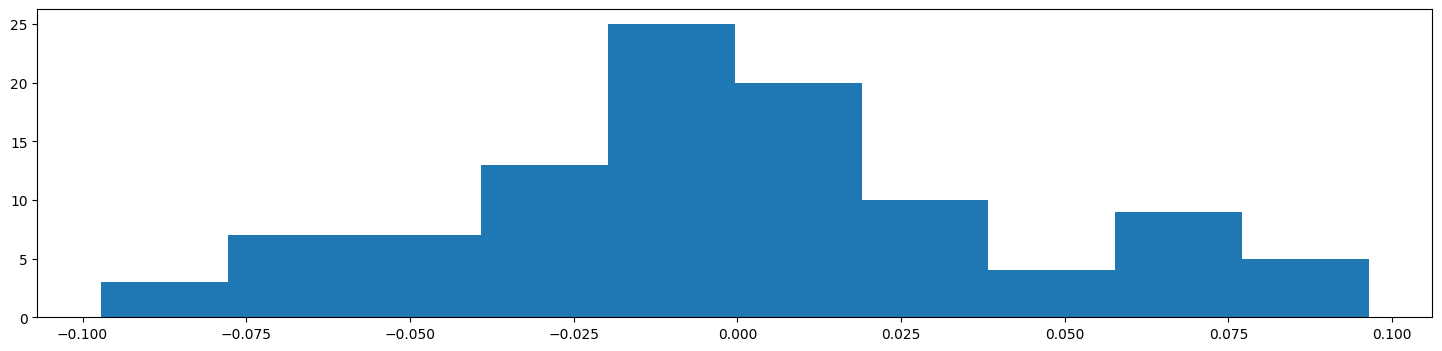

In [44]:
def normality_test(resids):

    _, p = sm.stats.diagnostic.kstest_normal(resids)

    if p < 0.05:
        print("Residuals are not normally distributed")
    else:
        print("Residuals are normally distributed")


normality_test(results.resid)

plt.hist(results.resid, bins=10);

In [45]:
GDP_TRANSFORMATIONS

,gdp_total,gdp_total_scaled,gdp_total_scaled_diff
1998-01-01,149317.0,-1.939067,NaN
1998-04-01,150392.0,-1.891425,0.047641
1998-07-01,151706.0,-1.833192,0.058233
1998-10-01,152911.0,-1.779790,0.053402
1999-01-01,155808.0,-1.651403,0.128387
...,...,...,...
2023-07-01,233430.0,1.788599,-0.045159
2023-10-01,233920.0,1.810315,0.021716
2024-01-01,233310.0,1.783281,-0.027034
2024-04-01,235834.0,1.895138,0.111857


In [46]:
def test_reverse_transform(start_date_analysis, my_data_to_untransform):

    GDP_StandardScaler_STD = np.std(GDP_TRANSFORMATIONS['gdp_total'])
    GDP_StandardScaler_MEAN = np.mean(GDP_TRANSFORMATIONS['gdp_total'])

    def diff_inv_Transformation(df_diff, first_value):
        series_inverted = np.r_[first_value, df_diff].cumsum().astype('float64')
        return series_inverted

    def std_inv_Transformation(data, std = GDP_StandardScaler_STD, mean = GDP_StandardScaler_MEAN):  
        return data * std + mean


    data_to_untransform = my_data_to_untransform
    date_start_difference = pd.to_datetime(start_date_analysis) 

    test1 = std_inv_Transformation(diff_inv_Transformation(data_to_untransform, GDP_TRANSFORMATIONS.loc[date_start_difference, 'gdp_total_scaled']))


    return test1

tes1 = test_reverse_transform(start_date_analysis, y_true)


In [47]:
# create new column with existing data from gdp_total_scaled_diff, then replace with predictions values
GDP_TRANSFORMATIONS["predicts_before_transformations"] = GDP_TRANSFORMATIONS['gdp_total_scaled_diff']
GDP_TRANSFORMATIONS.loc[end_test_date:, 'predicts_before_transformations'] = ynewpred

GDP_TRANSFORMATIONS

,gdp_total,gdp_total_scaled,gdp_total_scaled_diff,predicts_before_transformations
1998-01-01,149317.0,-1.939067,NaN,NaN
1998-04-01,150392.0,-1.891425,0.047641,0.047641
1998-07-01,151706.0,-1.833192,0.058233,0.058233
1998-10-01,152911.0,-1.779790,0.053402,0.053402
1999-01-01,155808.0,-1.651403,0.128387,0.128387
...,...,...,...,...
2023-07-01,233430.0,1.788599,-0.045159,-0.045159
2023-10-01,233920.0,1.810315,0.021716,0.021716
2024-01-01,233310.0,1.783281,-0.027034,-0.027034
2024-04-01,235834.0,1.895138,0.111857,0.329739


<Axes: >

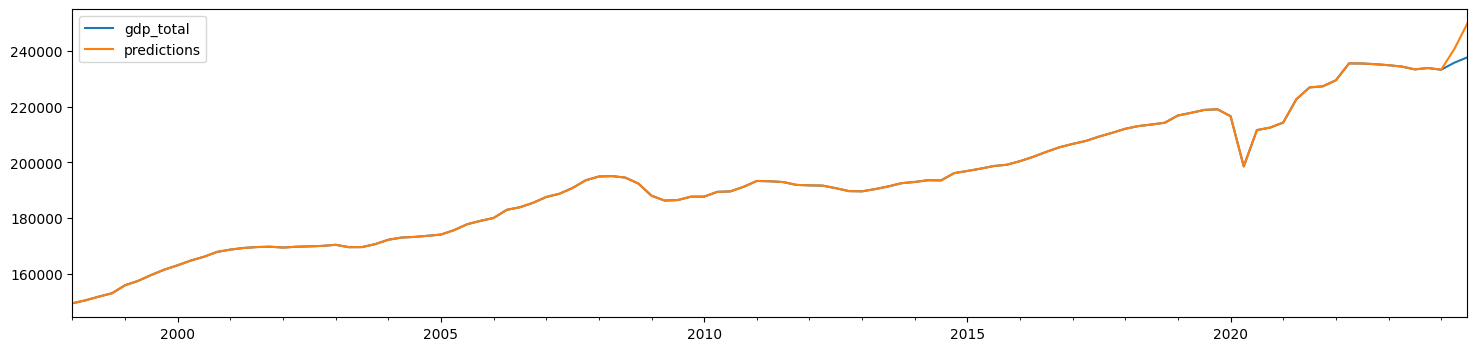

In [48]:
predictions = test_reverse_transform(start_date_analysis, GDP_TRANSFORMATIONS['predicts_before_transformations'].dropna().values)
GDP_TRANSFORMATIONS['predictions'] = predictions

GDP_TRANSFORMATIONS[['gdp_total', 'predictions']].plot()

In [49]:
GDP_TRANSFORMATIONS

,gdp_total,gdp_total_scaled,gdp_total_scaled_diff,predicts_before_transformations,predictions
1998-01-01,149317.0,-1.939067,NaN,NaN,149317.000000
1998-04-01,150392.0,-1.891425,0.047641,0.047641,150392.000000
1998-07-01,151706.0,-1.833192,0.058233,0.058233,151706.000000
1998-10-01,152911.0,-1.779790,0.053402,0.053402,152911.000000
1999-01-01,155808.0,-1.651403,0.128387,0.128387,155808.000000
...,...,...,...,...,...
2023-07-01,233430.0,1.788599,-0.045159,-0.045159,233430.000000
2023-10-01,233920.0,1.810315,0.021716,0.021716,233920.000000
2024-01-01,233310.0,1.783281,-0.027034,-0.027034,233310.000000
2024-04-01,235834.0,1.895138,0.111857,0.329739,240750.396090


<Axes: >

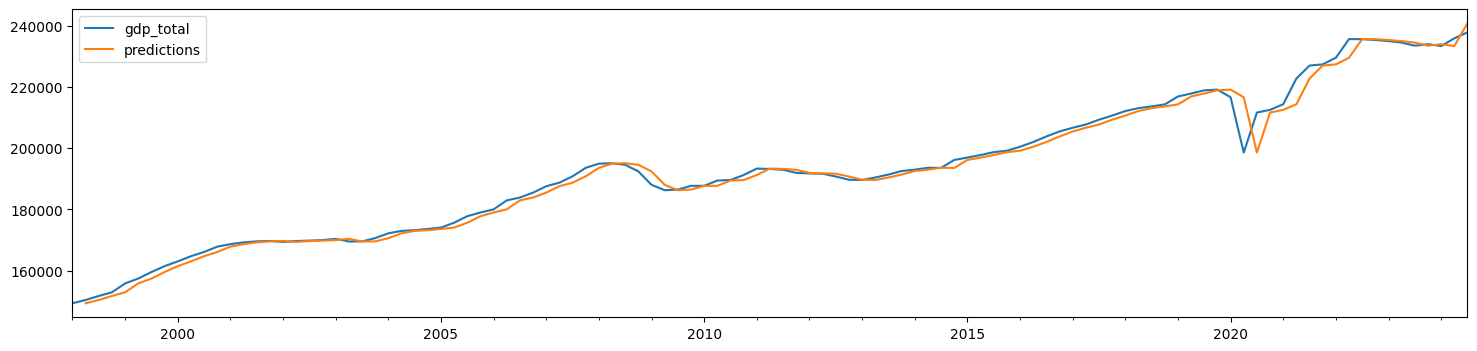

In [50]:

predictions = test_reverse_transform(start_date_analysis, GDP_TRANSFORMATIONS['predicts_before_transformations'].values[1:-1])
GDP_TRANSFORMATIONS['predictions'] = np.append(np.nan, predictions)

GDP_TRANSFORMATIONS[['gdp_total', 'predictions']].plot()